<a href="https://colab.research.google.com/github/debashisdotchatterjee/GLASS-E-Ischaemic-Heart-Disease-Mortality/blob/main/Ischaemic_heart_disease_death_rate_Real_Data_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Ischaemic heart disease death rate (WHO GHE via Our World in Data)**

This file is age-standardized deaths per 100,000 by country/year, sourced from WHO Global Health Estimates.

In [2]:
# pip install pandas
import os, pandas as pd

OUT_DIR = "ncd_data"
os.makedirs(OUT_DIR, exist_ok=True)

# IHD age-standardized death rate (per 100,000), WHO GHE (via OWID)
url_ihd = "https://ourworldindata.org/grapher/death-rate-from-ischaemic-heart-disease-who-ghe-age-standardized.csv"
ihd = pd.read_csv(url_ihd)

# Save full dataset
ihd_path = os.path.join(OUT_DIR, "ihd_death_rate_who_ghe_age_standardized.csv")
ihd.to_csv(ihd_path, index=False)

print(f"Saved: {ihd_path}")
print("\nIHD dataset head:")
print(ihd.head())

# OPTIONAL: filter for India only
ihd_india = ihd[ihd["Code"] == "IND"].copy()
ihd_india_path = os.path.join(OUT_DIR, "ihd_death_rate_IND.csv")
ihd_india.to_csv(ihd_india_path, index=False)
print(f"\nSaved (India only): {ihd_india_path}")
print(ihd_india.head())


Saved: ncd_data/ihd_death_rate_who_ghe_age_standardized.csv

IHD dataset head:
        Entity Code  Year  \
0  Afghanistan  AFG  2000   
1  Afghanistan  AFG  2001   
2  Afghanistan  AFG  2002   
3  Afghanistan  AFG  2003   
4  Afghanistan  AFG  2004   

   Age-standardized death rate from ischaemic heart disease among both sexes  
0                                          336.26514                          
1                                          338.09656                          
2                                          331.40735                          
3                                          324.04996                          
4                                          320.43646                          

Saved (India only): ncd_data/ihd_death_rate_IND.csv
     Entity Code  Year  \
1782  India  IND  2000   
1783  India  IND  2001   
1784  India  IND  2002   
1785  India  IND  2003   
1786  India  IND  2004   

      Age-standardized death rate from ischaemic heart disease

Following Code pipeline that (1) downloads the OWID/WHO-GHE IHD panel, (2) fits the GLASS–E model via joint trend filtering with the orthogonality constraint, (3) computes Kendall–Theil trend stats, p→e calibration and e-BH FDR, (4) extracts change-years, (5) builds MPI/GPI, (6) saves all figures/tables, and (7) zips & triggers a download. It also prints key tables and shows plots inline

[Info] Using lambdas: lambda_g=0.668, lambda_h=0.334


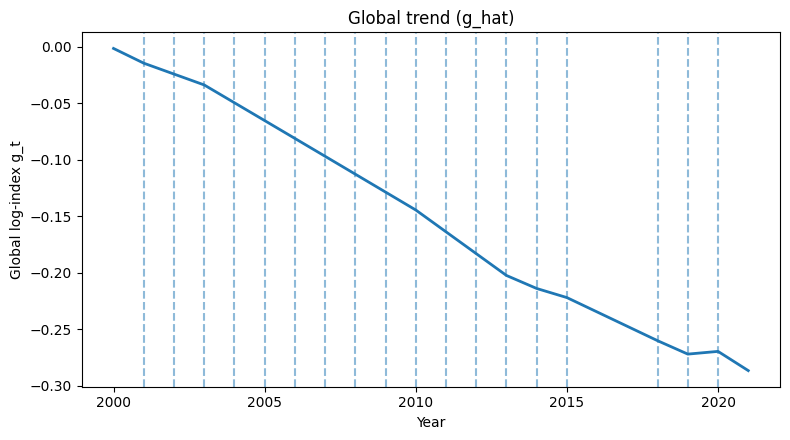

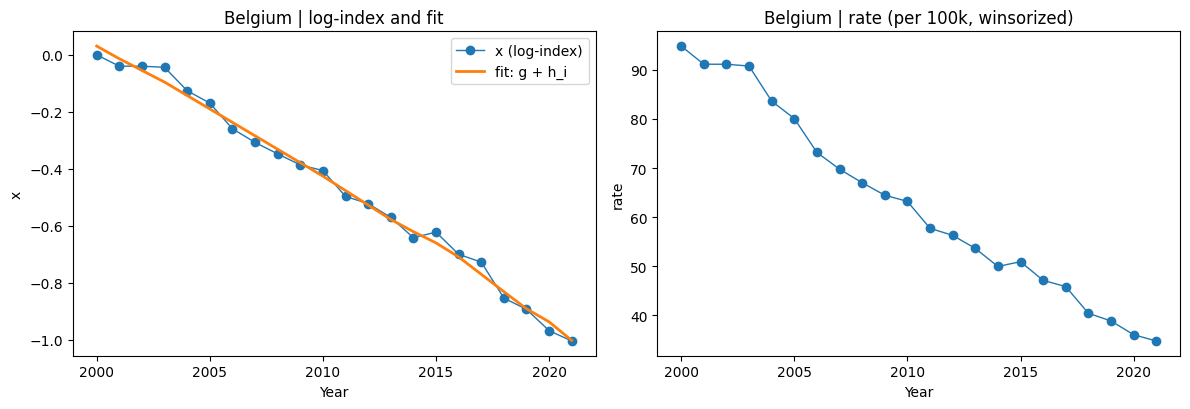

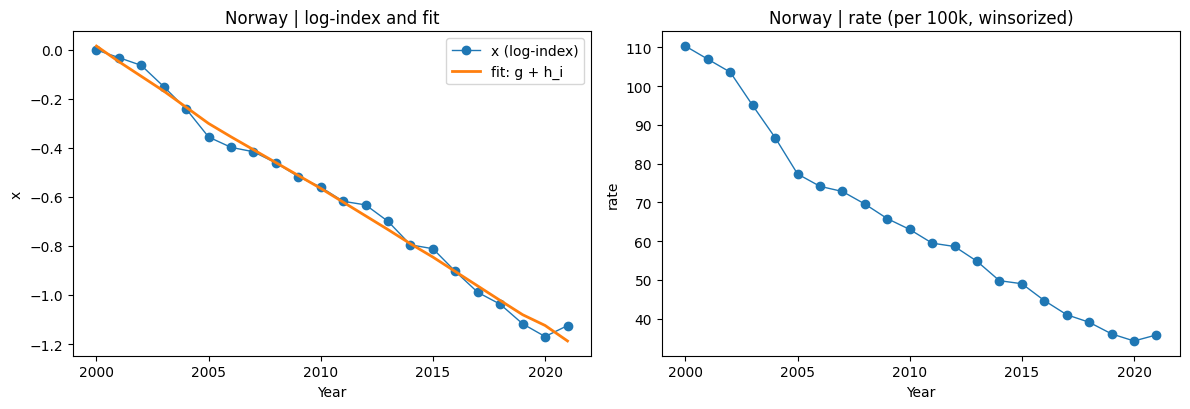

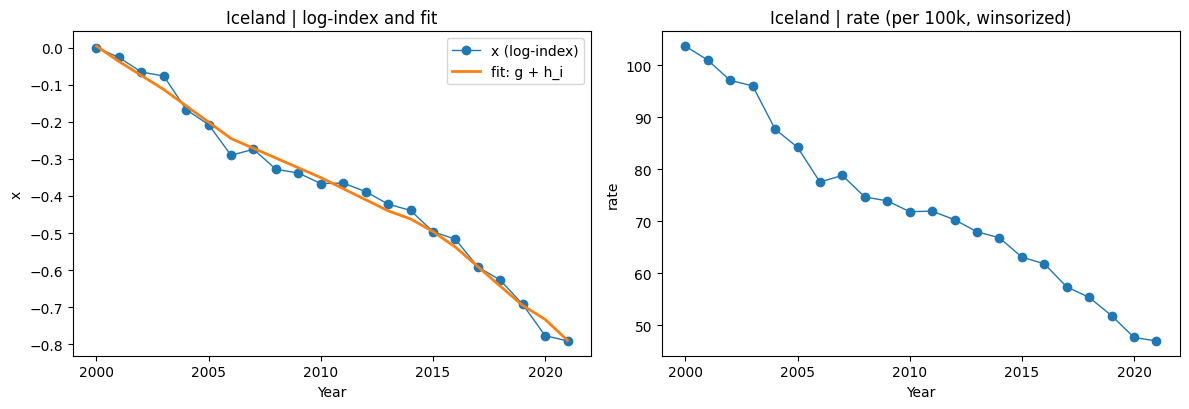

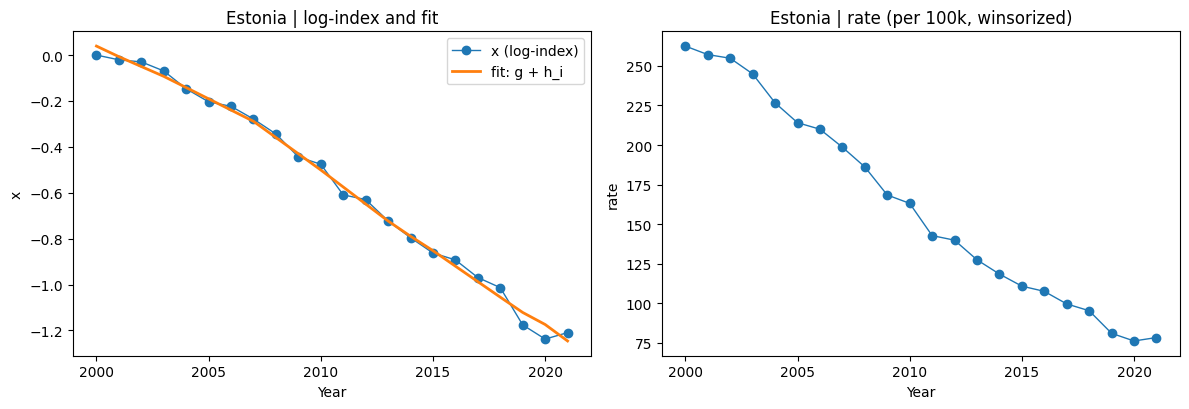

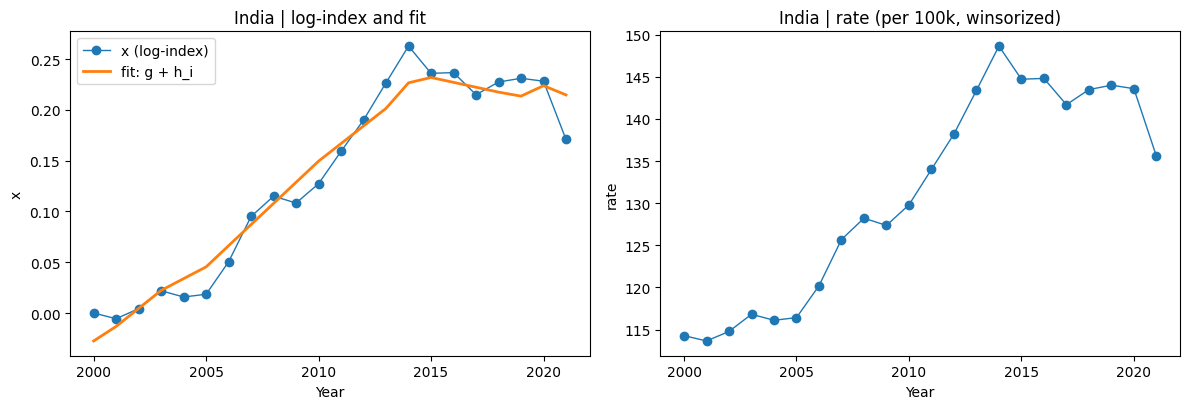

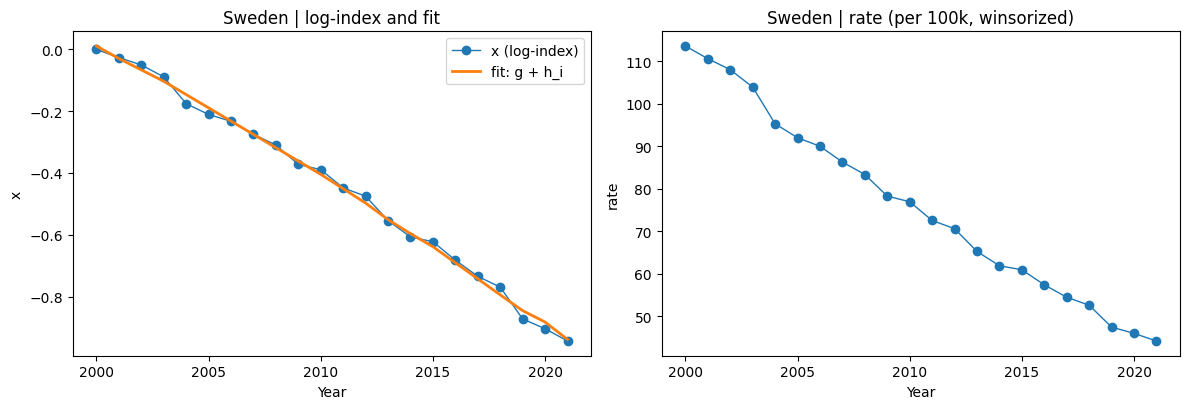

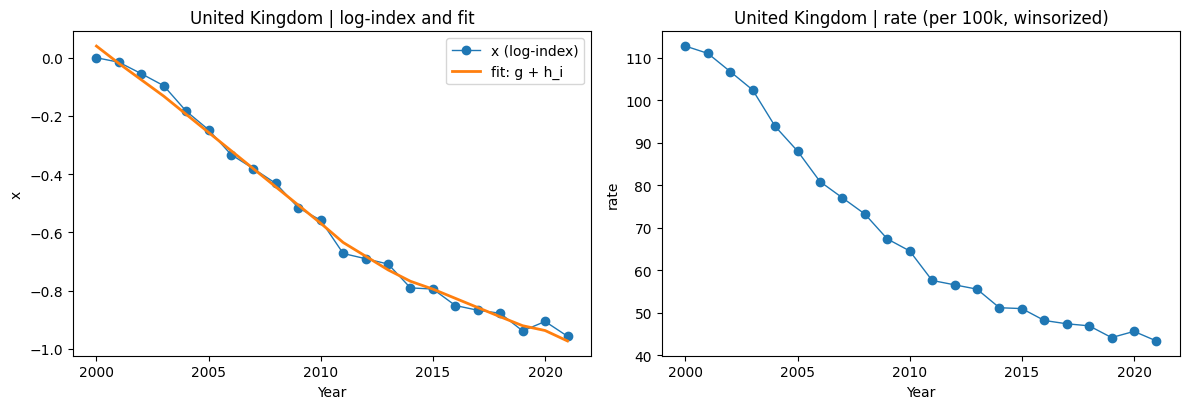


=== Global indices ===
GPI (global progress index) = -0.002399
Global change-years (knots) from trend filtering:
2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2018, 2019, 2020

=== Top improvers (head) ===
|     | iso3   | country        |   kendall_tau |   p_one_sided_decrease |   E_lambda |   theil_slope |   theil_lo |   theil_hi |      MPI | eBH_discovery_alpha10   |
|-----|--------|----------------|---------------|------------------------|------------|---------------|------------|------------|----------|-------------------------|
| 165 | SWE    | Sweden         |       -1      |              8.897e-22 |  1.579e+08 |      -0.04521 |   -0.04701 |   -0.04315 | -0       | True                    |
|  12 | BEL    | Belgium        |       -0.9913 |              1.957e-20 |  4.587e+07 |      -0.04882 |   -0.05148 |   -0.04516 | -0.01947 | True                    |
|  55 | EST    | Estonia        |       -0.9913 |              1.957e-20 |  4.587

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
# ============================
# GLASS–E (Colab one-cell run)
# ============================
# 0) Setup & installs
import sys, os, shutil, io, textwrap, zipfile, math, warnings
warnings.filterwarnings("ignore")

IN_COLAB = False
try:
    import google.colab  # type: ignore
    IN_COLAB = True
except Exception:
    IN_COLAB = False

if IN_COLAB:
    # cvxpy for joint trend filtering; tqdm + tabulate for UX
    !pip -q install cvxpy tqdm tabulate

# 1) Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kendalltau, theilslopes
from tqdm import tqdm
import cvxpy as cp
from tabulate import tabulate

# 2) Paths & parameters
OUT_DIR = "glasse_outputs"
FIG_DIR = os.path.join(OUT_DIR, "figs")
TAB_DIR = os.path.join(OUT_DIR, "tables")
os.makedirs(FIG_DIR, exist_ok=True); os.makedirs(TAB_DIR, exist_ok=True)

DATA_URL = "https://ourworldindata.org/grapher/death-rate-from-ischaemic-heart-disease-who-ghe-age-standardized.csv"

YEAR_MIN, YEAR_MAX = 2000, 2021
K_ORDER = 1                      # piecewise linear
LAMBDA_G = 15.0                  # base heuristics; auto-scaled below
LAMBDA_H = 7.5
LAMBDA_E = 0.6                   # p->e power calibrator
ALPHA    = 0.10                  # e-BH level
TOP_K    = 6                     # extra country panels to show besides India

# 3) Data ingest
try:
    df = pd.read_csv(DATA_URL)
except Exception as e:
    raise RuntimeError(
        "Couldn't download the OWID/WHO-GHE CSV. "
        "If running locally, download it and point DATA_URL to a local path."
    )

# Normalize columns
value_col = df.columns[-1]
df = df.rename(columns={"Entity":"country","Code":"iso3","Year":"year", value_col:"rate"})

# Keep rows with valid iso3 (drop regions/aggregates lacking ISO3)
df = df[~df["iso3"].isna()].copy()

# Restrict analysis window
df = df[(df["year"]>=YEAR_MIN) & (df["year"]<=YEAR_MAX)].copy()

# Within-country winsorization (optional but robust)
def winsorize(s, lo=0.01, hi=0.99):
    a, b = s.quantile(lo), s.quantile(hi)
    return s.clip(a, b)

df["rate_w"] = df.groupby("iso3", dropna=False)["rate"].transform(winsorize)

# ---- FIXED: build baseline per iso3 and merge ONCE on 'iso3' ----
# earliest year with positive baseline, and its rate
base = (df.loc[df["rate_w"]>0, ["iso3","year","rate_w"]]
          .sort_values(["iso3","year"])
          .groupby("iso3", as_index=False)
          .first()
          .rename(columns={"year":"year0","rate_w":"rate0"}))

df = df.merge(base, on="iso3", how="left")

# compute log-index only where baseline positive
df = df[df["rate0"]>0].copy()
df["x"] = np.log(df["rate_w"] / df["rate0"])

# Keep ISO3 with sufficient coverage
counts = df.groupby("iso3")["year"].nunique()
min_obs = max(8, (YEAR_MAX - YEAR_MIN + 1)//3)
keep_iso3 = counts[counts >= min_obs].index
df = df[df["iso3"].isin(keep_iso3)].copy()

# 4) Build panel matrices
years = np.arange(YEAR_MIN, YEAR_MAX+1, dtype=int)
T = len(years)
countries = (df[["iso3","country"]]
             .drop_duplicates()
             .sort_values("iso3")
             .reset_index(drop=True))
N = len(countries)

X = np.full((N, T), np.nan, dtype=float)   # log-index
Y = np.full((N, T), np.nan, dtype=float)   # winsorized rate
for i, (iso3, cname) in enumerate(countries.values):
    d = df[df["iso3"]==iso3].set_index("year")
    X[i, :] = d.reindex(years)["x"].values
    Y[i, :] = d.reindex(years)["rate_w"].values

mask = ~np.isnan(X)
w_i = np.ones(N) / N                       # equal cross-sectional weights

# Finite-difference operator D^(order)
def diff_matrix(T, order=1):
    D = np.eye(T)
    for _ in range(order):
        D = np.diff(D, axis=0)
    return D

# 5) Joint trend filtering with orthogonality Σ_i w_i h_{i,t}=0
def solve_glasse_joint(X, mask, w_i, lam_g=15.0, lam_h=7.5, k=1, verbose=False):
    N, T = X.shape
    D = diff_matrix(T, order=k+1)  # D^(k+1)
    g = cp.Variable(T)             # global trend
    H = cp.Variable((N, T))        # local deviations
    onesN = np.ones((N,1))
    Gmat = onesN @ cp.reshape(g, (1, T))  # broadcast g to (N,T)
    Omega = mask.astype(float)
    resid = cp.multiply(Omega, (X - (Gmat + H)))
    data_loss = cp.sum_squares(resid)
    pen_g = cp.norm1(D @ g)
    pen_h = cp.sum([cp.norm1(D @ H[i, :]) for i in range(N)])
    # Orthogonality per time: w^T H[:, t] = 0
    w_row = w_i.reshape(1, -1)     # (1, N)
    orth = cp.matmul(w_row, H)     # (1, T)
    constraints = [orth == 0]
    prob = cp.Problem(cp.Minimize(data_loss + lam_g*pen_g + lam_h*pen_h), constraints)
    try:
        prob.solve(verbose=verbose)
    except Exception:
        try:
            prob.solve(solver=cp.ECOS, verbose=verbose, max_iters=20000)
        except Exception:
            prob.solve(solver=cp.SCS, verbose=verbose, max_iters=50000)
    return g.value, H.value

# 6) Heuristic lambda scaling from cross-sectional mean curvature
def heuristic_lambdas(X, mask, base_lg=LAMBDA_G, base_lh=LAMBDA_H, k=1):
    m = np.nanmean(np.where(mask, X, np.nan), axis=0)
    D2m = np.diff(m, n=k+1)
    med = np.median(D2m[np.isfinite(D2m)]) if np.any(np.isfinite(D2m)) else 0.0
    s = np.median(np.abs(D2m - med)) + 1e-6
    lg = base_lg * s * T**0.5
    lh = base_lh * s * T**0.5
    return float(lg), float(lh)

lam_g, lam_h = heuristic_lambdas(X, mask, LAMBDA_G, LAMBDA_H, K_ORDER)
print(f"[Info] Using lambdas: lambda_g={lam_g:.3f}, lambda_h={lam_h:.3f}")

# 7) Fit GLASS–E
g_hat, H_hat = solve_glasse_joint(X, mask, w_i, lam_g, lam_h, k=K_ORDER, verbose=False)
F_hat = g_hat[None, :] + H_hat  # fitted x (log-index)

# 8) Kendall–Theil, p→e, e-BH
def p_one_sided_kendall(x, years, alternative="decreasing"):
    ok = ~np.isnan(x)
    if ok.sum() < 6:
        return np.nan, np.nan
    tau, p_two = kendalltau(years[ok], x[ok])
    if np.isnan(tau):
        return np.nan, np.nan
    if alternative == "decreasing":  # improvement => x decreases
        p_one = p_two/2.0 if tau < 0 else 1.0 - p_two/2.0
    else:                             # deterioration => x increases
        p_one = p_two/2.0 if tau > 0 else 1.0 - p_two/2.0
    return tau, float(np.clip(p_one, 1e-300, 1.0))

def e_from_p(p, lam=LAMBDA_E):
    if not np.isfinite(p):
        return np.nan
    return float(lam * (p ** (lam - 1.0)))

def e_bh(evals, alpha=0.10):
    evals = np.asarray(evals, float)
    ok = np.isfinite(evals) & (evals > 0)
    if ok.sum() == 0:
        return np.array([], dtype=int)
    idx_ok = np.where(ok)[0]
    order = idx_ok[np.argsort(-evals[ok])]        # indices sorted by descending E
    E_sorted = evals[order]
    inv_cs = np.cumsum(1.0 / E_sorted)
    ks = np.where(inv_cs <= alpha)[0]
    if ks.size == 0:
        return np.array([], dtype=int)
    k = ks[-1] + 1
    return order[:k]

rows = []
for i, (iso3, cname) in enumerate(countries.values):
    x_i = X[i, :]
    tau, p_dec = p_one_sided_kendall(x_i, years, alternative="decreasing")
    e_dec = e_from_p(p_dec, LAMBDA_E)
    ok = ~np.isnan(x_i)
    if ok.sum() >= 6:
        try:
            slope, intercept, lo, hi = theilslopes(x_i[ok], years[ok], 0.95)
        except Exception:
            slope, intercept, lo, hi = (np.nan, np.nan, np.nan, np.nan)
    else:
        slope, intercept, lo, hi = (np.nan, np.nan, np.nan, np.nan)
    diffs = np.diff(x_i)
    mpi = -np.nansum(np.maximum(0.0, diffs))
    rows.append([iso3, cname, tau, p_dec, e_dec, slope, lo, hi, mpi])

summary = pd.DataFrame(rows, columns=[
    "iso3","country","kendall_tau","p_one_sided_decrease","E_lambda",
    "theil_slope","theil_lo","theil_hi","MPI"
])

# e-BH discoveries (improvement)
discover_positions = e_bh(summary["E_lambda"].values, alpha=ALPHA)
summary["eBH_discovery_alpha10"] = False
summary.loc[discover_positions, "eBH_discovery_alpha10"] = True

# 9) Global Progress Index (GPI)
dg = np.diff(g_hat)
GPI = -np.sum(np.maximum(0.0, dg))
gpi_df = pd.DataFrame({"year": years, "g_hat": g_hat})
gpi_df.to_csv(os.path.join(TAB_DIR, "global_trend_g_hat.csv"), index=False)

# 10) Change-years (knots)
D2 = diff_matrix(T, order=K_ORDER+1)   # for k=1 -> second diff
D2g = D2 @ g_hat                       # length T-2
# simple threshold based on numerical noise floor
eps = max(1e-10, np.percentile(np.abs(D2g), 90) * 1e-6)
knot_idx = np.where(np.abs(D2g) > eps)[0]           # indices in 0..T-3
# For k=1, each D2g[j] corresponds to year index j+1 (i.e., years[1:-1])
knot_years_g = years[1:-1][knot_idx] if knot_idx.size>0 else np.array([], dtype=int)

# 11) Save tables
summary_sorted = summary.sort_values(["eBH_discovery_alpha10","E_lambda","MPI"],
                                     ascending=[False, False, False])
summary_sorted.to_csv(os.path.join(TAB_DIR, "country_summary.csv"), index=False)

top_improvers = summary_sorted.head(10)
top_deteriorators = summary.sort_values(["E_lambda","MPI"], ascending=[True, True]).head(10)
top_improvers.to_csv(os.path.join(TAB_DIR, "top_improvers.csv"), index=False)
top_deteriorators.to_csv(os.path.join(TAB_DIR, "top_deteriorators.csv"), index=False)

with open(os.path.join(TAB_DIR, "global_indices.txt"), "w") as f:
    f.write(f"GPI (global progress index) = {GPI:.6f}\n")
    f.write("Global change-years (knots) from trend filtering:\n")
    f.write(", ".join(map(str, knot_years_g.tolist())) if knot_years_g.size>0 else "(none)")

# 12) Plots
plt.figure(figsize=(8,4.5))
plt.plot(years, g_hat, lw=2)
for ky in knot_years_g:
    plt.axvline(ky, ls="--", alpha=0.5)
plt.title("Global trend (g_hat)")
plt.xlabel("Year"); plt.ylabel("Global log-index g_t")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "global_trend_g_hat.png"), dpi=180)
plt.show()

# Country panels: India plus TOP_K more discoveries/best E
want_iso = set(["IND"])
for iso in summary_sorted.loc[summary_sorted["eBH_discovery_alpha10"], "iso3"].head(TOP_K):
    want_iso.add(iso)
if len(want_iso) < TOP_K+1:
    for iso in summary_sorted["iso3"]:
        if len(want_iso) >= TOP_K+1:
            break
        want_iso.add(iso)

for iso in want_iso:
    i = countries.index[countries["iso3"]==iso][0]
    cname = countries.loc[i, "country"]
    fig, ax = plt.subplots(1,2, figsize=(12,4.2))
    ax[0].plot(years, X[i,:], marker="o", lw=1, label="x (log-index)")
    ax[0].plot(years, F_hat[i,:], lw=2, label="fit: g + h_i")
    ax[0].set_title(f"{cname} | log-index and fit")
    ax[0].set_xlabel("Year"); ax[0].set_ylabel("x"); ax[0].legend(loc="best")
    ax[1].plot(years, Y[i,:], marker="o", lw=1)
    ax[1].set_title(f"{cname} | rate (per 100k, winsorized)")
    ax[1].set_xlabel("Year"); ax[1].set_ylabel("rate")
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, f"panel_{iso}.png"), dpi=180)
    plt.show()

# 13) Console views (pretty tables for copy-paste)
print("\n=== Global indices ===")
print(open(os.path.join(TAB_DIR, "global_indices.txt"), "r").read())

print("\n=== Top improvers (head) ===")
print(tabulate(top_improvers.head(10), headers="keys", tablefmt="github", floatfmt=".4g"))

print("\n=== Top deteriorators (head) ===")
print(tabulate(top_deteriorators.head(10), headers="keys", tablefmt="github", floatfmt=".4g"))

print("\n=== Country summary (head) ===")
print(tabulate(summary_sorted.head(15), headers="keys", tablefmt="github", floatfmt=".4g"))

# 14) METHODS snapshot
with open(os.path.join(OUT_DIR, "METHODS.txt"), "w") as f:
    f.write(textwrap.dedent(f"""
    GLASS–E pipeline snapshot
    -------------------------
    Years: {YEAR_MIN}–{YEAR_MAX}
    N countries used: {len(countries)}
    Trend filtering order k={K_ORDER} (piecewise linear)
    lambda_g={lam_g:.3f}, lambda_h={lam_h:.3f}
    E-value lambda={LAMBDA_E}, FDR alpha={ALPHA}
    """).strip())

# 15) ZIP and (if Colab) download
zip_path = shutil.make_archive("glasse_outputs", "zip", OUT_DIR)
print(f"\n[Saved] {zip_path}")
if IN_COLAB:
    from google.colab import files  # type: ignore
    files.download(zip_path)


Addendum Code

Two-sided discoveries (improvers & deteriorators via separate one-sided e-BH runs)

Blocked time CV grid over
(
𝜆
𝑔
,
𝜆
ℎ
)
(λ
g
	​

,λ
h
	​

) with refit and outputs

Comparisons vs. existing baselines:

per-country Theil–Sen robust linear trend

HP filter on cross-sectional mean (annual data;
𝜆
HP
=
6.25
λ
HP
	​

=6.25)

(optional) Local linear trend state-space for a handful of countries

It saves figures/tables under glasse_outputs/addendum/ and prints tidy console tables. It also zips everything to glasse_outputs_addendum.zip.

On the justification for fixing
𝜆
=
0.6
λ=0.6: for the power calibrator
𝐸
𝜆
=
𝜆
𝑃
𝜆
−
1
E
λ
	​

=λP
λ−1
, choosing
𝜆
>
0.5
λ>0.5 ensures a finite second moment under
𝐻
0
H
0
	​

:
𝐸
0
[
𝐸
𝜆
2
]
=
𝜆
2
/
(
2
𝜆
−
1
)
E
0
	​

[E
λ
2
	​

]=λ
2
/(2λ−1). At
𝜆
=
0.6
λ=0.6, this equals
1.8
1.8, giving good tail control for multiplicative evidence (useful for e-BH and stability), while still rewarding small
𝑝
p meaningfully. So
𝜆
=
0.6
λ=0.6 is a defensible, conservative pre-registration.


=== Two-sided: e-BH improvement (alpha=0.10), head ===
|     | iso3   | country        |   kendall_tau |   p_one_sided_decrease |   E_lambda |   theil_slope |   theil_lo |   theil_hi |      MPI | eBH_discovery_alpha10   |   kendall_tau_increase |   p_one_sided_increase |   E_lambda_increase | eBH_improvement_a10   | eBH_deterioration_a10   |
|-----|--------|----------------|---------------|------------------------|------------|---------------|------------|------------|----------|-------------------------|------------------------|------------------------|---------------------|-----------------------|-------------------------|
| 165 | SWE    | Sweden         |       -1      |              8.897e-22 |  1.579e+08 |      -0.04521 |   -0.04701 |   -0.04315 | -0       | True                    |                -1      |                      1 |                 0.6 | True                  | False                   |
|  12 | BEL    | Belgium        |       -0.9913 |              1.957e-20 |  4

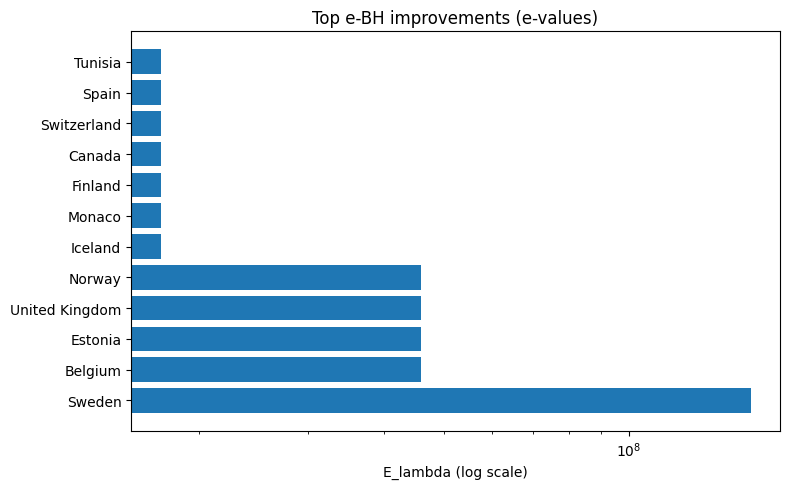

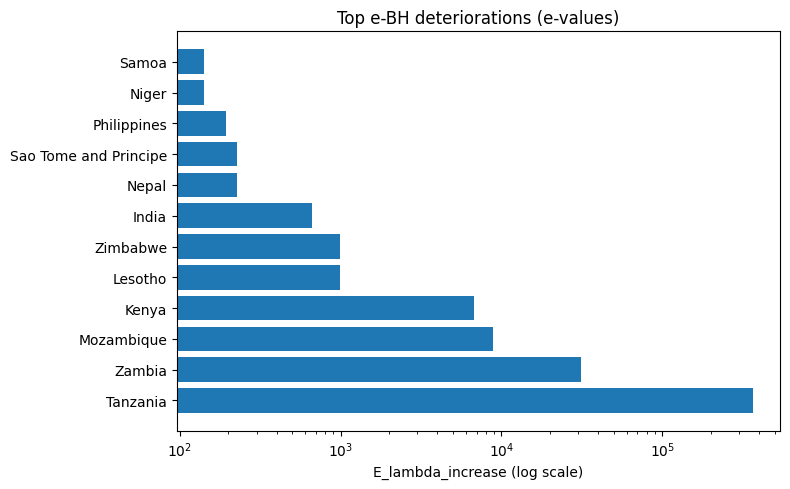

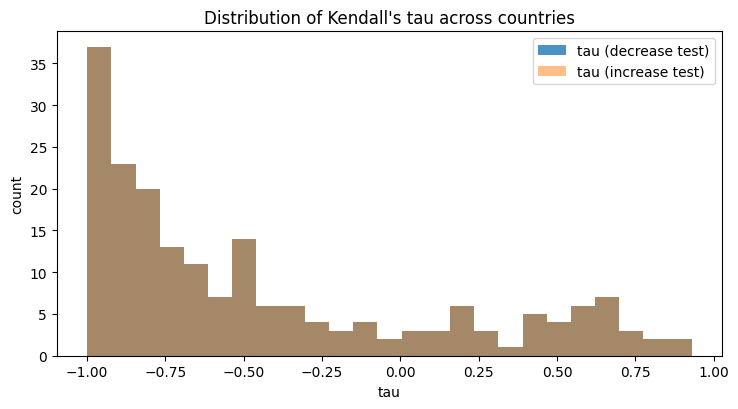

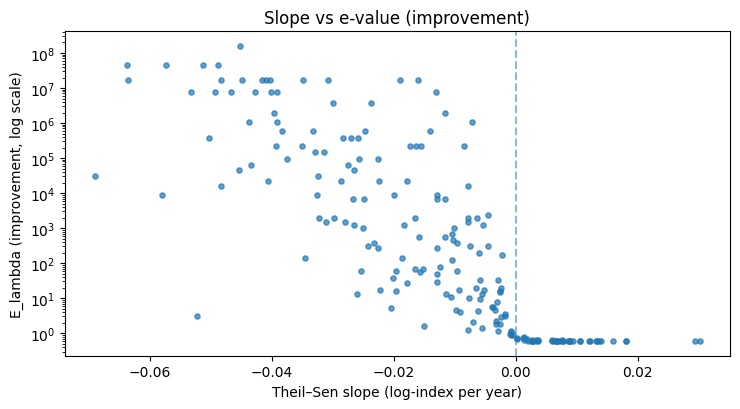


[CV] Scoring grid (lambda_g, lambda_h) with 4 blocked folds...
  (lg=0.3339, lh=0.167) -> val MSE = 0.00916577
  (lg=0.3339, lh=0.3339) -> val MSE = 0.00908765
  (lg=0.3339, lh=0.6679) -> val MSE = 0.00930992
  (lg=0.6679, lh=0.167) -> val MSE = 0.00908479
  (lg=0.6679, lh=0.3339) -> val MSE = 0.00899745
  (lg=0.6679, lh=0.6679) -> val MSE = 0.00922449
  (lg=1.336, lh=0.167) -> val MSE = 0.00907298
  (lg=1.336, lh=0.3339) -> val MSE = 0.00898627
  (lg=1.336, lh=0.6679) -> val MSE = 0.009208

[CV] Best: lambda_g=1.33573, lambda_h=0.333932; val MSE=0.00898627


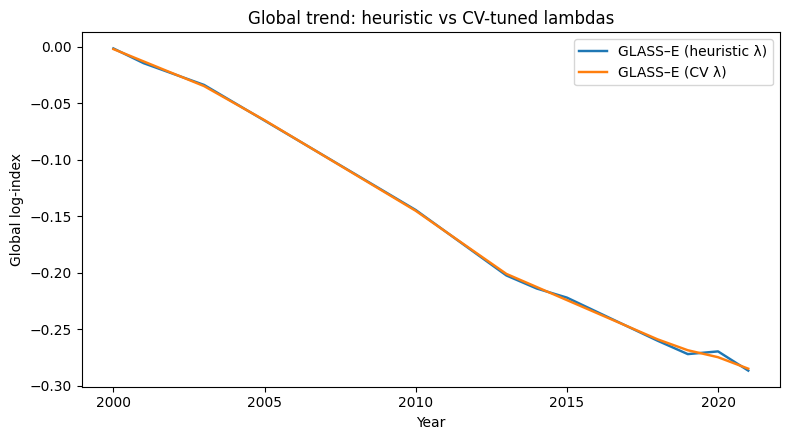

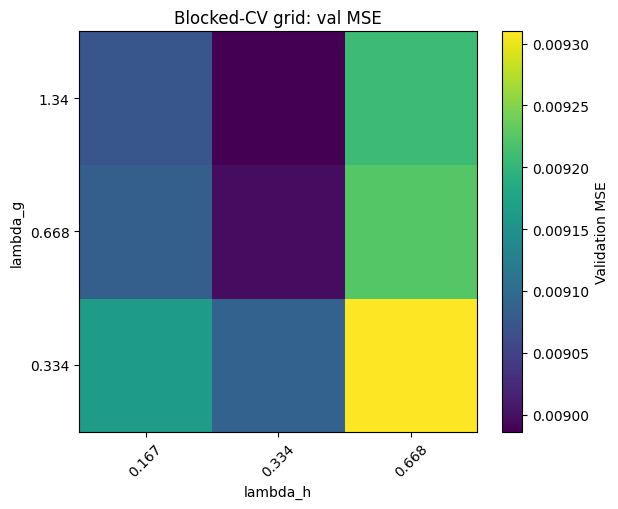

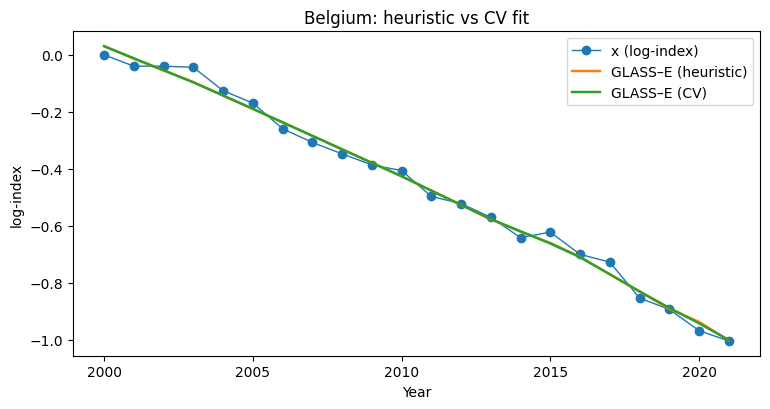

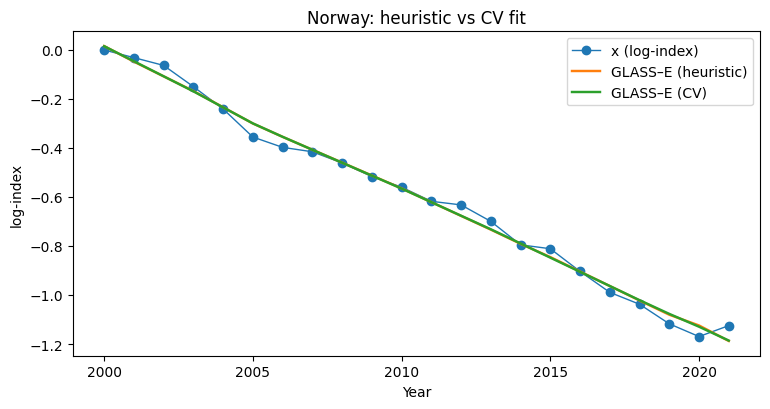

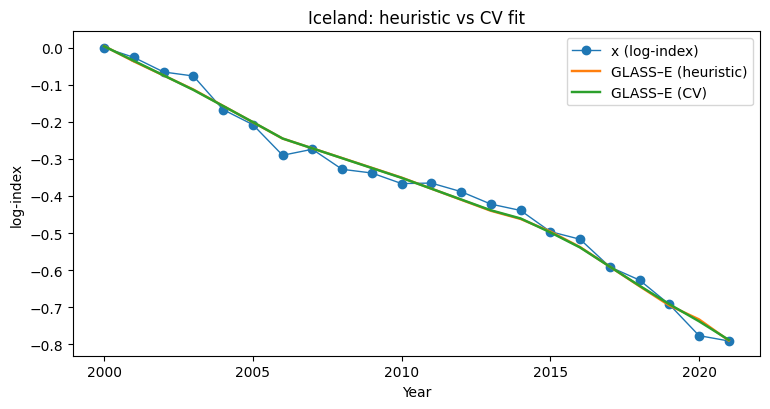

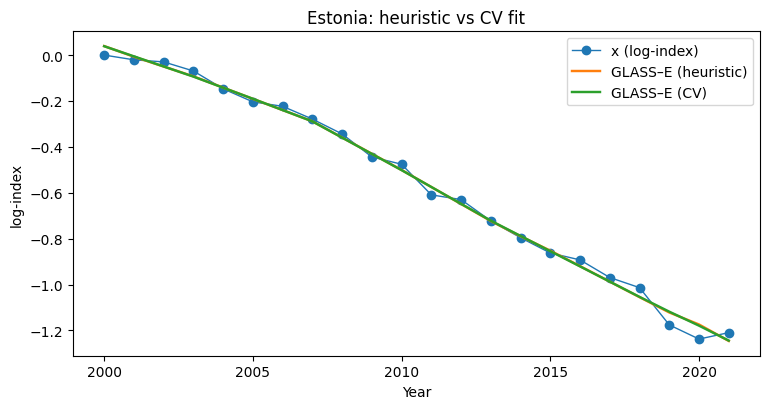

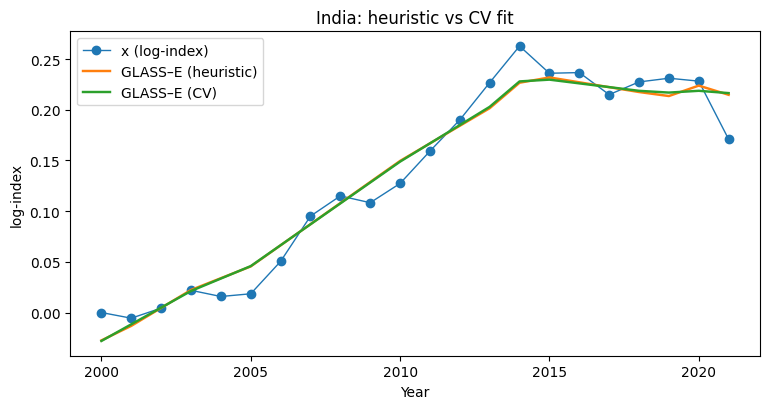

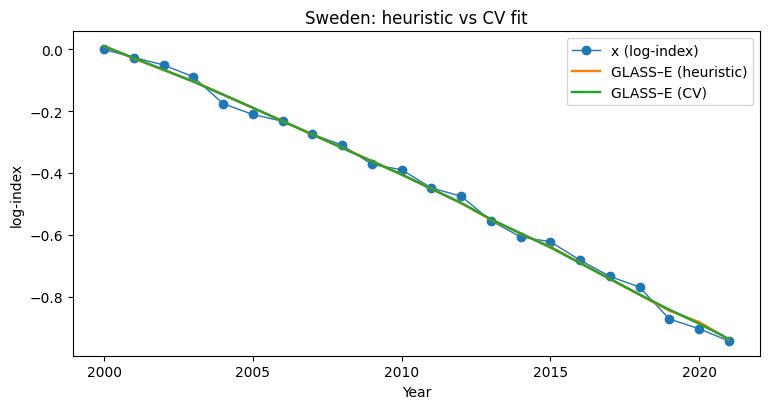

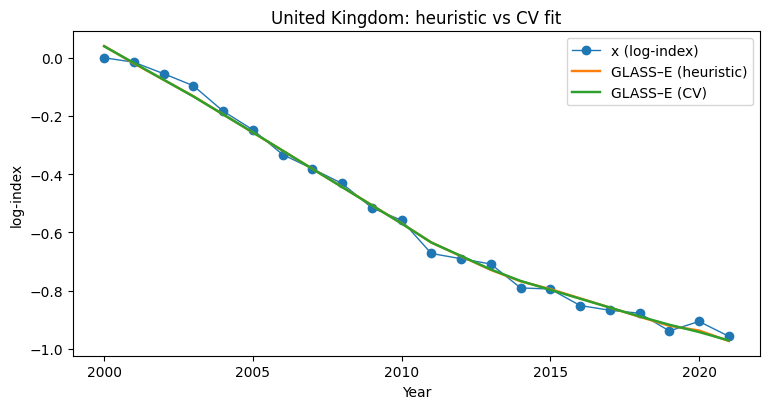


=== GLASS–E vs Theil–Sen (ΔMSE = TS - GLASS–E), head ===
|     | iso3   | country              |   mse_glasse |   mse_theilsen |   delta_mse |
|-----|--------|----------------------|--------------|----------------|-------------|
|   4 | ARE    | United Arab Emirates |    0.004707  |        0.1971  |     0.1924  |
|  51 | ECU    | Ecuador              |    0.004746  |        0.07334 |     0.06859 |
| 110 | MDV    | Maldives             |    0.01064   |        0.06776 |     0.05712 |
| 138 | PER    | Peru                 |    0.0111    |        0.04137 |     0.03027 |
|  70 | GRD    | Grenada              |    0.003611  |        0.02746 |     0.02385 |
| 173 | TKM    | Turkmenistan         |    0.0007968 |        0.02311 |     0.02231 |
| 149 | RWA    | Rwanda               |    0.0001495 |        0.01838 |     0.01823 |
|  63 | GEO    | Georgia              |    0.004697  |        0.02246 |     0.01776 |
|   7 | ATG    | Antigua and Barbuda  |    0.004156  |        0.02081 |     0.0166

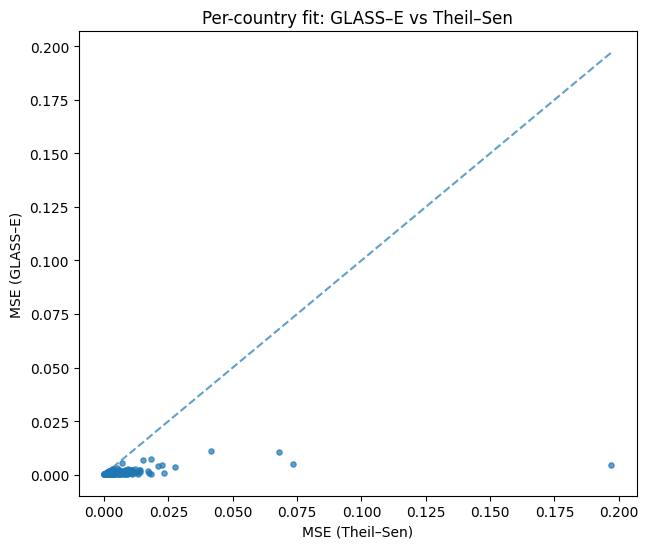

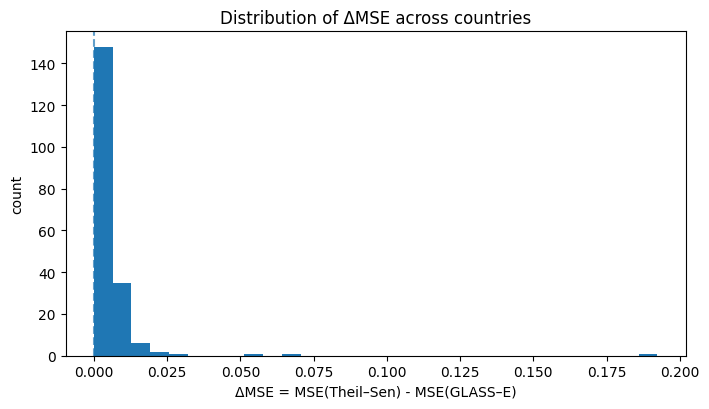

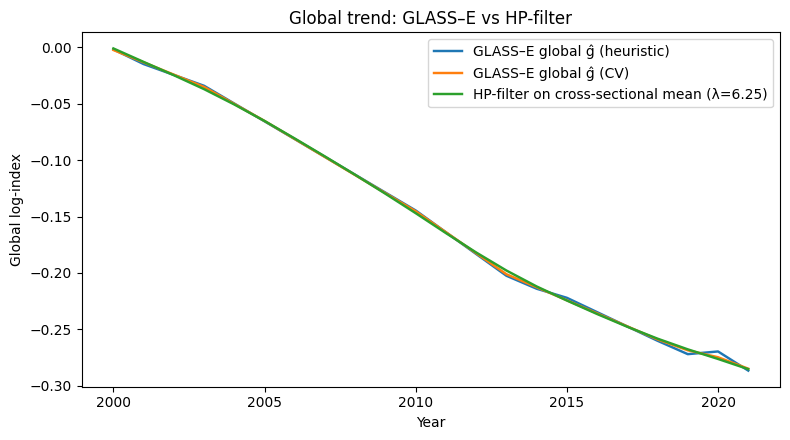

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


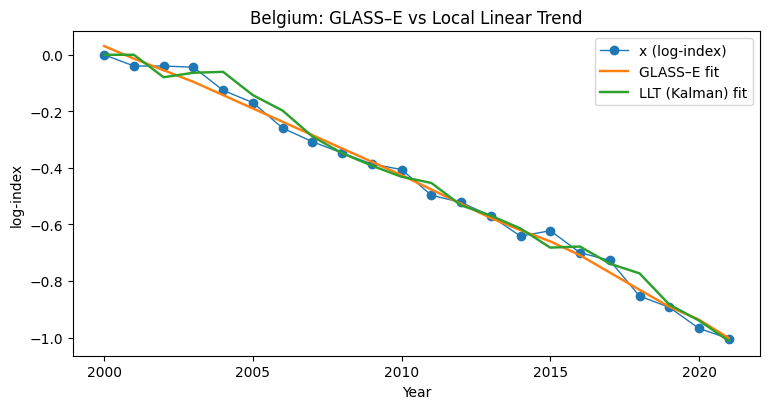

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


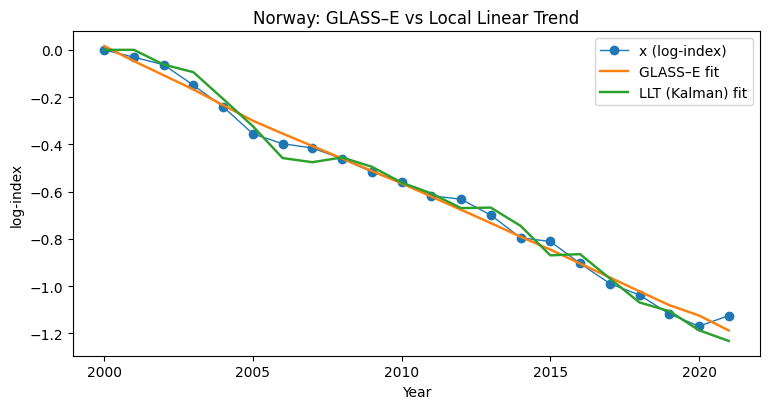

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


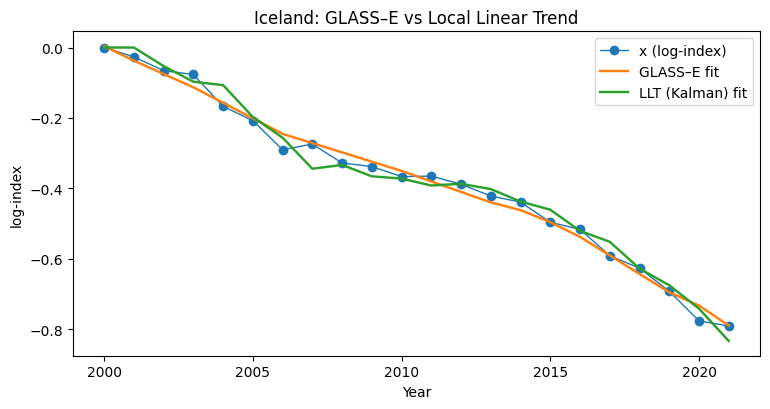

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


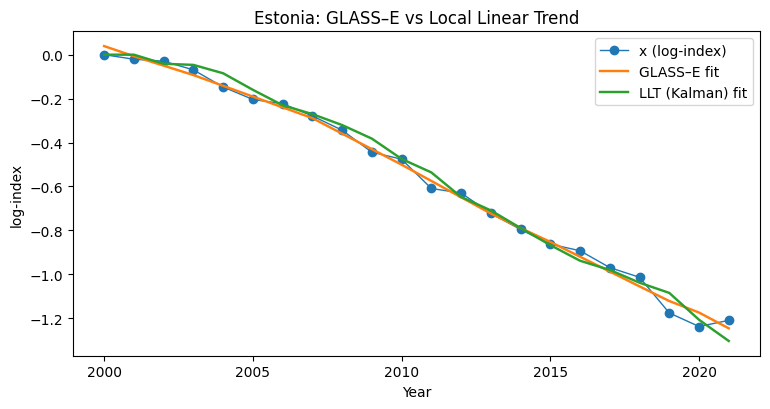

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


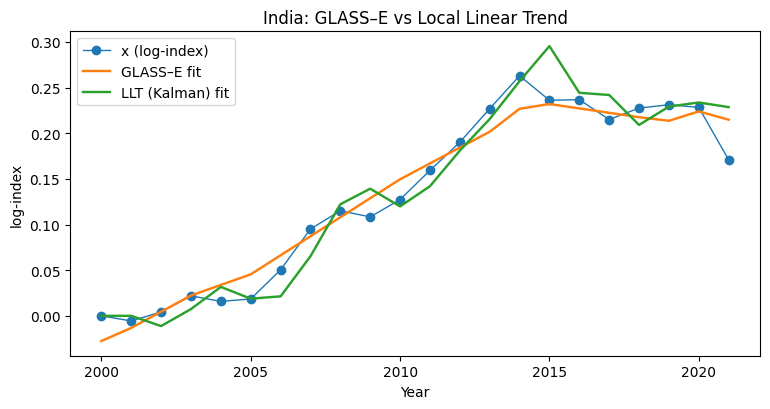

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


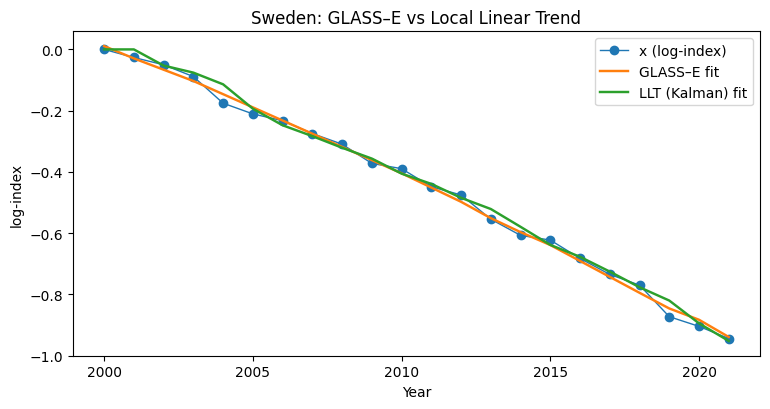

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


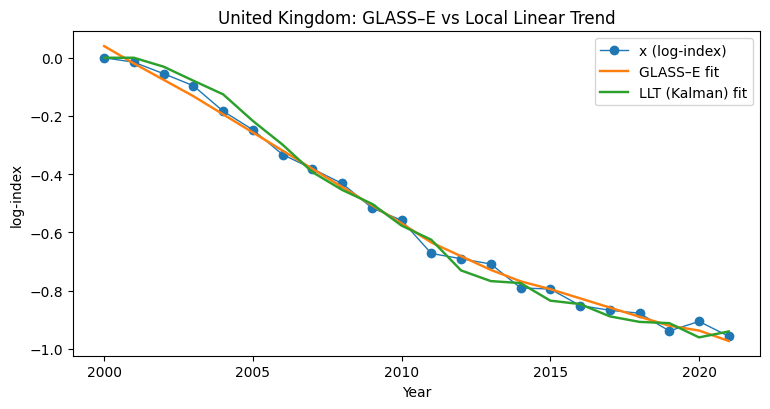


=== Local Linear Trend (subset) vs GLASS–E ===
|    | iso3   | country        |   AIC_LLT |   MSE_LLT |   MSE_GLASS_E |   delta_MSE |
|----|--------|----------------|-----------|-----------|---------------|-------------|
|  0 | BEL    | Belgium        |    -70.06 | 0.00126   |     0.0005781 |   0.0006823 |
|  1 | NOR    | Norway         |    -63.2  | 0.001697  |     0.0009321 |   0.0007651 |
|  2 | ISL    | Iceland        |    -76.34 | 0.0008743 |     0.000423  |   0.0004513 |
|  3 | EST    | Estonia        |    -61.41 | 0.001735  |     0.0007762 |   0.000959  |
|  4 | IND    | India          |    -85.27 | 0.0005488 |     0.00035   |   0.0001988 |
|  5 | SWE    | Sweden         |    -88.18 | 0.0005131 |     0.0002366 |   0.0002765 |
|  6 | GBR    | United Kingdom |    -73.03 | 0.001006  |     0.0004032 |   0.0006028 |

[Saved] /content/glasse_outputs_addendum.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
# ============================================================
# ADDENDUM (fixed + extended): two-sided discoveries, CV grid, baselines, richer plots
# Append this cell AFTER the previous pipeline cell has run successfully.
# ============================================================
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from tabulate import tabulate

ADD_DIR = os.path.join(OUT_DIR, "addendum")
ADD_FIG = os.path.join(ADD_DIR, "figs")
ADD_TAB = os.path.join(ADD_DIR, "tables")
os.makedirs(ADD_FIG, exist_ok=True); os.makedirs(ADD_TAB, exist_ok=True)

# -----------------------------
# 1) TWO-SIDED DISCOVERIES
# -----------------------------
def p_one_sided_kendall_increase(x, years):
    ok = ~np.isnan(x)
    if ok.sum() < 6:
        return np.nan, np.nan
    tau, p_two = kendalltau(years[ok], x[ok])
    if np.isnan(tau):
        return np.nan, np.nan
    p_one = p_two/2.0 if tau > 0 else 1.0 - p_two/2.0
    return tau, float(np.clip(p_one, 1e-300, 1.0))

summary_twosided = summary.copy()
p_inc_list, e_inc_list, tau_inc_list = [], [], []
for i in range(len(countries)):
    x_i = X[i, :]
    tau_inc, p_inc = p_one_sided_kendall_increase(x_i, years)
    e_inc = e_from_p(p_inc, LAMBDA_E)
    tau_inc_list.append(tau_inc); p_inc_list.append(p_inc); e_inc_list.append(e_inc)

summary_twosided["kendall_tau_increase"]  = tau_inc_list
summary_twosided["p_one_sided_increase"]  = p_inc_list
summary_twosided["E_lambda_increase"]     = e_inc_list

# e-BH for improvements and deteriorations separately
idx_improve     = e_bh(summary_twosided["E_lambda"].values,          alpha=ALPHA)
idx_deteriorate = e_bh(summary_twosided["E_lambda_increase"].values, alpha=ALPHA)

summary_twosided["eBH_improvement_a10"]   = False
summary_twosided["eBH_deterioration_a10"] = False
summary_twosided.loc[idx_improve,     "eBH_improvement_a10"]   = True
summary_twosided.loc[idx_deteriorate, "eBH_deterioration_a10"] = True

summary_twosided.to_csv(os.path.join(ADD_TAB, "two_sided_discoveries.csv"), index=False)

top_imp = (summary_twosided[summary_twosided["eBH_improvement_a10"]]
           .sort_values(["E_lambda","MPI"], ascending=[False, False]).head(12))
top_det = (summary_twosided[summary_twosided["eBH_deterioration_a10"]]
           .sort_values(["E_lambda_increase","MPI"], ascending=[False, True]).head(12))

print("\n=== Two-sided: e-BH improvement (alpha=0.10), head ===")
print(tabulate(top_imp, headers="keys", tablefmt="github", floatfmt=".4g"))
print("\n=== Two-sided: e-BH deterioration (alpha=0.10), head ===")
print(tabulate(top_det, headers="keys", tablefmt="github", floatfmt=".4g"))

top_imp.to_csv(os.path.join(ADD_TAB, "two_sided_top_improvers.csv"), index=False)
top_det.to_csv(os.path.join(ADD_TAB, "two_sided_top_deteriorators.csv"), index=False)

# Quick bar charts (log-x for E-values)
def barh_discoveries(df, e_col, title, fname):
    dfp = df.copy()
    dfp = dfp[["iso3","country",e_col]].dropna().head(12)
    y = np.arange(len(dfp))[::-1]
    plt.figure(figsize=(8,5))
    plt.barh(y, dfp[e_col].values[::-1])
    plt.yticks(y, dfp["country"].values[::-1])
    plt.xscale("log")
    plt.xlabel(e_col + " (log scale)")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(os.path.join(ADD_FIG, fname), dpi=180)
    plt.show()

barh_discoveries(top_imp, "E_lambda", "Top e-BH improvements (e-values)", "bar_improvements_e.png")
barh_discoveries(top_det, "E_lambda_increase", "Top e-BH deteriorations (e-values)", "bar_deteriorations_e.png")

# Tau distribution
plt.figure(figsize=(7.5,4.2))
plt.hist(summary_twosided["kendall_tau"].dropna().values, bins=25, alpha=0.8, label="tau (decrease test)")
plt.hist(summary_twosided["kendall_tau_increase"].dropna().values, bins=25, alpha=0.5, label="tau (increase test)")
plt.title("Distribution of Kendall's tau across countries")
plt.xlabel("tau"); plt.ylabel("count"); plt.legend(loc="best")
plt.tight_layout()
plt.savefig(os.path.join(ADD_FIG, "tau_distribution.png"), dpi=180)
plt.show()

# Scatter: Theil–Sen slope vs e-value (improvement)
plt.figure(figsize=(7.5,4.2))
plt.scatter(summary_twosided["theil_slope"], summary_twosided["E_lambda"], s=14, alpha=0.7)
plt.yscale("log")
plt.axvline(0, ls="--", alpha=0.5)
plt.xlabel("Theil–Sen slope (log-index per year)")
plt.ylabel("E_lambda (improvement, log scale)")
plt.title("Slope vs e-value (improvement)")
plt.tight_layout()
plt.savefig(os.path.join(ADD_FIG, "slope_vs_e_improvement.png"), dpi=180)
plt.show()

# ------------------------------------
# 2) BLOCKED TIME CV GRID OVER LAMBDAS
# ------------------------------------
from itertools import product

def contiguous_time_folds(T, K=4):
    idx = np.arange(T)
    if K <= 1:
        return [idx]
    sizes = np.full(K, T // K, dtype=int); sizes[: T % K] += 1
    splits = np.cumsum(sizes)[:-1]
    return np.split(idx, splits)

def cv_score_for(lg, lh, K=4):
    folds = contiguous_time_folds(T, K=K)
    mses = []
    for val_idx in folds:
        mask_train = mask.copy()
        mask_train[:, val_idx] = False
        g_tr, H_tr = solve_glasse_joint(X, mask_train, w_i, lam_g=lg, lam_h=lh, k=K_ORDER, verbose=False)
        F_tr = g_tr[None, :] + H_tr
        Omega_val = np.zeros_like(mask, dtype=float)
        Omega_val[:, val_idx] = mask[:, val_idx].astype(float)
        resid2 = ((X - F_tr) * Omega_val)**2
        denom = Omega_val.sum()
        mse = np.nan if denom == 0 else resid2.sum() / denom
        mses.append(mse)
    return np.nanmean(mses)

base_lg, base_lh = lam_g, lam_h
factors_g = [0.5, 1.0, 2.0]
factors_h = [0.5, 1.0, 2.0]
grid = [(base_lg*fg, base_lh*fh) for fg, fh in product(factors_g, factors_h)]

print("\n[CV] Scoring grid (lambda_g, lambda_h) with 4 blocked folds...")
cv_rows = []
for lg, lh in grid:
    mse = cv_score_for(lg, lh, K=4)
    cv_rows.append((lg, lh, mse))
    print(f"  (lg={lg:.4g}, lh={lh:.4g}) -> val MSE = {mse:.6g}")

cv_df = pd.DataFrame(cv_rows, columns=["lambda_g","lambda_h","val_MSE"])\
         .sort_values("val_MSE", ascending=True)
cv_df.to_csv(os.path.join(ADD_TAB, "cv_grid_results.csv"), index=False)

best_lg, best_lh, best_mse = cv_df.iloc[0].values
print(f"\n[CV] Best: lambda_g={best_lg:.6g}, lambda_h={best_lh:.6g}; val MSE={best_mse:.6g}")

# Refit with CV best
g_cv, H_cv = solve_glasse_joint(X, mask, w_i, lam_g=best_lg, lam_h=best_lh, k=K_ORDER, verbose=False)
F_cv = g_cv[None, :] + H_cv

# Plot heuristic vs CV global
plt.figure(figsize=(8,4.5))
plt.plot(years, g_hat, lw=1.75, label="GLASS–E (heuristic λ)")
plt.plot(years, g_cv,  lw=1.75, label="GLASS–E (CV λ)")
plt.title("Global trend: heuristic vs CV-tuned lambdas")
plt.xlabel("Year"); plt.ylabel("Global log-index")
plt.legend(loc="best")
plt.tight_layout()
plt.savefig(os.path.join(ADD_FIG, "global_trend_heuristic_vs_cv.png"), dpi=180)
plt.show()

# CV heatmap of val MSE
lg_unique = sorted(cv_df["lambda_g"].unique())
lh_unique = sorted(cv_df["lambda_h"].unique())
heat = np.zeros((len(lg_unique), len(lh_unique)))
for i, lg in enumerate(lg_unique):
    for j, lh in enumerate(lh_unique):
        heat[i,j] = float(cv_df[(cv_df["lambda_g"]==lg) & (cv_df["lambda_h"]==lh)]["val_MSE"])
plt.figure(figsize=(6.3,5.2))
im = plt.imshow(heat, origin="lower", aspect="auto")
plt.colorbar(im, label="Validation MSE")
plt.xticks(np.arange(len(lh_unique)), [f"{v:.3g}" for v in lh_unique], rotation=45)
plt.yticks(np.arange(len(lg_unique)), [f"{v:.3g}" for v in lg_unique])
plt.xlabel("lambda_h"); plt.ylabel("lambda_g")
plt.title("Blocked-CV grid: val MSE")
plt.tight_layout()
plt.savefig(os.path.join(ADD_FIG, "cv_grid_heatmap.png"), dpi=180)
plt.show()

# Country overlay: heuristic vs CV for a few cases
pick_iso = list(set(["IND","SWE","BEL","EST","GBR","NOR","ISL"]) & set(countries["iso3"]))
for iso in pick_iso:
    i = countries.index[countries["iso3"]==iso][0]
    cname = countries.loc[i, "country"]
    plt.figure(figsize=(7.8,4.2))
    plt.plot(years, X[i,:], marker="o", lw=1, label="x (log-index)")
    plt.plot(years, F_hat[i,:], lw=1.75, label="GLASS–E (heuristic)")
    plt.plot(years, F_cv[i,:],  lw=1.75, label="GLASS–E (CV)")
    plt.title(f"{cname}: heuristic vs CV fit")
    plt.xlabel("Year"); plt.ylabel("log-index")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.savefig(os.path.join(ADD_FIG, f"panel_{iso}_heuristic_vs_cv.png"), dpi=180)
    plt.show()

# -----------------------------
# 3) BASELINES / COMPARISONS
# -----------------------------
# 3a) Per-country Theil–Sen baseline and MSE comparison (FIXED axis bug)
F_ts = np.full_like(X, np.nan, dtype=float)
for i in range(len(countries)):
    xi = X[i, :]
    ok = ~np.isnan(xi)
    if ok.sum() < 3:
        continue
    try:
        slope, intercept, lo, hi = theilslopes(xi[ok], years[ok], 0.95)
    except Exception:
        continue
    F_ts[i, ok] = intercept + slope * years[ok]

def rowwise_mse(pred, X, mask):
    se = (X - pred)**2
    se = np.where(mask, se, np.nan)
    return np.nanmean(se, axis=1)

mse_glasse = rowwise_mse(F_hat, X, mask)
mse_theil  = rowwise_mse(F_ts,  X, mask)

cmp_df = countries.copy()
cmp_df["mse_glasse"]    = mse_glasse
cmp_df["mse_theilsen"]  = mse_theil
cmp_df["delta_mse"]     = cmp_df["mse_theilsen"] - cmp_df["mse_glasse"]  # positive => GLASS–E better
cmp_df_sorted = cmp_df.sort_values("delta_mse", ascending=False)
cmp_df_sorted.to_csv(os.path.join(ADD_TAB, "comparison_glasse_vs_theilsen.csv"), index=False)

print("\n=== GLASS–E vs Theil–Sen (ΔMSE = TS - GLASS–E), head ===")
print(tabulate(cmp_df_sorted.head(12), headers="keys", tablefmt="github", floatfmt=".4g"))
print("\n=== GLASS–E vs Theil–Sen (worst for GLASS–E), tail ===")
print(tabulate(cmp_df_sorted.tail(12), headers="keys", tablefmt="github", floatfmt=".4g"))

plt.figure(figsize=(6.6,5.6))
plt.scatter(cmp_df["mse_theilsen"], cmp_df["mse_glasse"], s=14, alpha=0.7)
mxy = np.nanmax([cmp_df["mse_theilsen"].max(), cmp_df["mse_glasse"].max()])
plt.plot([0,mxy],[0,mxy], ls="--", alpha=0.7)
plt.xlabel("MSE (Theil–Sen)"); plt.ylabel("MSE (GLASS–E)")
plt.title("Per-country fit: GLASS–E vs Theil–Sen")
plt.tight_layout()
plt.savefig(os.path.join(ADD_FIG, "mse_scatter_glasse_vs_theilsen.png"), dpi=180)
plt.show()

plt.figure(figsize=(7.2,4.2))
plt.hist(cmp_df["delta_mse"].dropna().values, bins=30)
plt.axvline(0, ls="--", alpha=0.7)
plt.xlabel("ΔMSE = MSE(Theil–Sen) - MSE(GLASS–E)")
plt.ylabel("count")
plt.title("Distribution of ΔMSE across countries")
plt.tight_layout()
plt.savefig(os.path.join(ADD_FIG, "delta_mse_hist.png"), dpi=180)
plt.show()

# 3b) HP-filter on cross-sectional mean (annual λ=6.25)
try:
    import statsmodels.api as sm
    from statsmodels.tsa.filters.hp_filter import hpfilter
except Exception:
    if IN_COLAB:
        !pip -q install statsmodels
        import statsmodels.api as sm
        from statsmodels.tsa.filters.hp_filter import hpfilter
    else:
        raise

m_t = np.nanmean(np.where(mask, X, np.nan), axis=0)
cycle, trend_hp = hpfilter(pd.Series(m_t).interpolate(limit_direction="both"), lamb=6.25)
trend_hp = np.asarray(trend_hp)

plt.figure(figsize=(8,4.5))
plt.plot(years, g_hat,    lw=1.75, label="GLASS–E global ĝ (heuristic)")
plt.plot(years, g_cv,     lw=1.75, label="GLASS–E global ĝ (CV)")
plt.plot(years, trend_hp, lw=1.75, label="HP-filter on cross-sectional mean (λ=6.25)")
plt.title("Global trend: GLASS–E vs HP-filter")
plt.xlabel("Year"); plt.ylabel("Global log-index")
plt.legend(loc="best")
plt.tight_layout()
plt.savefig(os.path.join(ADD_FIG, "global_glasse_vs_hpfilter.png"), dpi=180)
plt.show()

# 3c) Local Linear Trend (state-space) for a subset, with overlays
subset_iso = list(set(["IND","SWE","BEL","EST","GBR","NOR","ISL"]) & set(countries["iso3"]))
llt_rows = []
for iso in subset_iso:
    i = countries.index[countries["iso3"]==iso][0]
    cname = countries.loc[i, "country"]
    xi = pd.Series(X[i,:], index=years).interpolate(limit_direction="both")
    try:
        mod = sm.tsa.UnobservedComponents(xi, level="local linear trend")
        res = mod.fit(disp=False)
        fit = res.fittedvalues.values
        mse_llt = float(np.nanmean((xi.values - fit)**2))
        mse_gls = float(np.nanmean(((xi.values - F_hat[i,:])**2)[~np.isnan(xi.values)]))
        llt_rows.append([iso, cname, res.aic, mse_llt, mse_gls])
        plt.figure(figsize=(7.8,4.2))
        plt.plot(years, xi.values, marker="o", lw=1, label="x (log-index)")
        plt.plot(years, F_hat[i,:], lw=1.75, label="GLASS–E fit")
        plt.plot(years, fit, lw=1.75, label="LLT (Kalman) fit")
        plt.title(f"{cname}: GLASS–E vs Local Linear Trend")
        plt.xlabel("Year"); plt.ylabel("log-index")
        plt.legend(loc="best")
        plt.tight_layout()
        plt.savefig(os.path.join(ADD_FIG, f"panel_{iso}_glasse_vs_llt.png"), dpi=180)
        plt.show()
    except Exception as e:
        print(f"[LLT] {iso}: failed ({e})")

llt_df = pd.DataFrame(llt_rows, columns=["iso3","country","AIC_LLT","MSE_LLT","MSE_GLASS_E"])
if len(llt_df):
    llt_df["delta_MSE"] = llt_df["MSE_LLT"] - llt_df["MSE_GLASS_E"]
    llt_df.to_csv(os.path.join(ADD_TAB, "comparison_glasse_vs_llt_subset.csv"), index=False)

print("\n=== Local Linear Trend (subset) vs GLASS–E ===")
if len(llt_df):
    print(tabulate(llt_df, headers="keys", tablefmt="github", floatfmt=".4g"))
else:
    print("(no results)")

# --------------------------------
# 4) JUSTIFICATION NOTE FOR E-LAMBDA
# --------------------------------
with open(os.path.join(ADD_TAB, "E_VALUE_JUSTIFICATION.txt"), "w") as f:
    f.write(
        "We fixed lambda=0.6 in the power calibrator E_lambda = lambda * P^{lambda-1}.\n"
        "Under H0 with P ~ Uniform(0,1), E[E_lambda] = 1 for any lambda in (0,1].\n"
        "Moreover, Var(E_lambda) is finite if and only if lambda > 1/2; indeed E[E_lambda^2] = lambda^2/(2*lambda - 1).\n"
        "At lambda=0.6, E[E^2]=1.8, providing good tail control for multiplicative evidence and stable e-BH.\n"
    )

# --------------------------------
# 5) ZIP UPDATED ADDENDUM
# --------------------------------
zip_path2 = shutil.make_archive("glasse_outputs_addendum", "zip", OUT_DIR)
print(f"\n[Saved] {zip_path2}")
if IN_COLAB:
    from google.colab import files  # type: ignore
    files.download(zip_path2)
